<a href="https://colab.research.google.com/github/mjiii25/prac_class/blob/main/team-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 데이터 로드 및 건물별 전력사용량 파악

In [1]:
library(data.table)
library(magrittr)
library(ggplot2)
library(plotly)
#install.packages("factoextra")
#library(factoextra)


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




In [4]:
dt_train = fread('/content/train.csv')
names(dt_train) = c('num', 'date_time', '전력사용량', '기온', '풍속', '습도', '강수량', '일조', 
                    '비전기냉방설비운영', '태양광보유')
head(dt_train)

num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-06-01 00,8179.056,17.6,2.5,92,0.8,0,0,0
1,2020-06-01 01,8135.640,17.7,2.9,91,0.3,0,0,0
1,2020-06-01 02,8107.128,17.5,3.2,91,0.0,0,0,0
1,2020-06-01 03,8048.808,17.1,3.2,91,0.0,0,0,0
1,2020-06-01 04,8043.624,17.0,3.3,92,0.0,0,0,0
1,2020-06-01 05,8010.576,16.9,3.4,93,0.0,0,0,0


In [5]:
dt_train[, date_time := as.POSIXct(date_time, tz = '', format = '%F %H')]
dt_train[, `:=`(date = as.Date(date_time, tz=''),
                 hour = as.factor(format(date_time, format='%H')),
                 dow  = as.factor(format(date_time, format='%u')))]
head(dt_train)

num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,date,hour,dow
<int>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<fct>,<fct>
1,2020-06-01 00:00:00,8179.056,17.6,2.5,92,0.8,0,0,0,2020-06-01,00,1
1,2020-06-01 01:00:00,8135.640,17.7,2.9,91,0.3,0,0,0,2020-06-01,01,1
1,2020-06-01 02:00:00,8107.128,17.5,3.2,91,0.0,0,0,0,2020-06-01,02,1
1,2020-06-01 03:00:00,8048.808,17.1,3.2,91,0.0,0,0,0,2020-06-01,03,1
1,2020-06-01 04:00:00,8043.624,17.0,3.3,92,0.0,0,0,0,2020-06-01,04,1
1,2020-06-01 05:00:00,8010.576,16.9,3.4,93,0.0,0,0,0,2020-06-01,05,1


날짜시간 변수 형식을 활용해서 새로운 변수 date(날짜), hour(시간), dow(요일) 추출

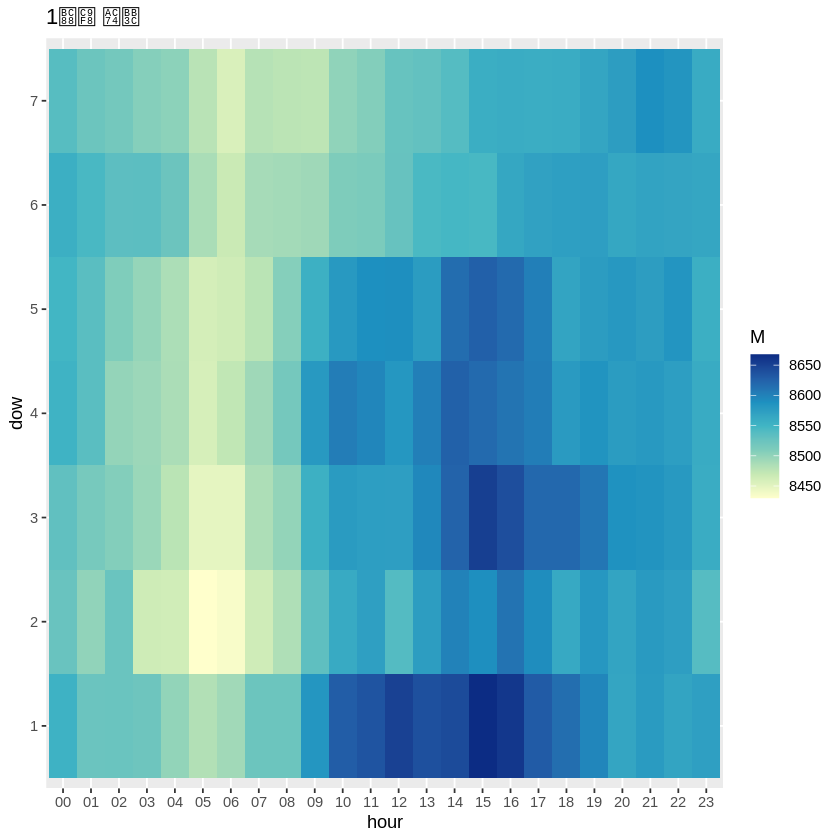

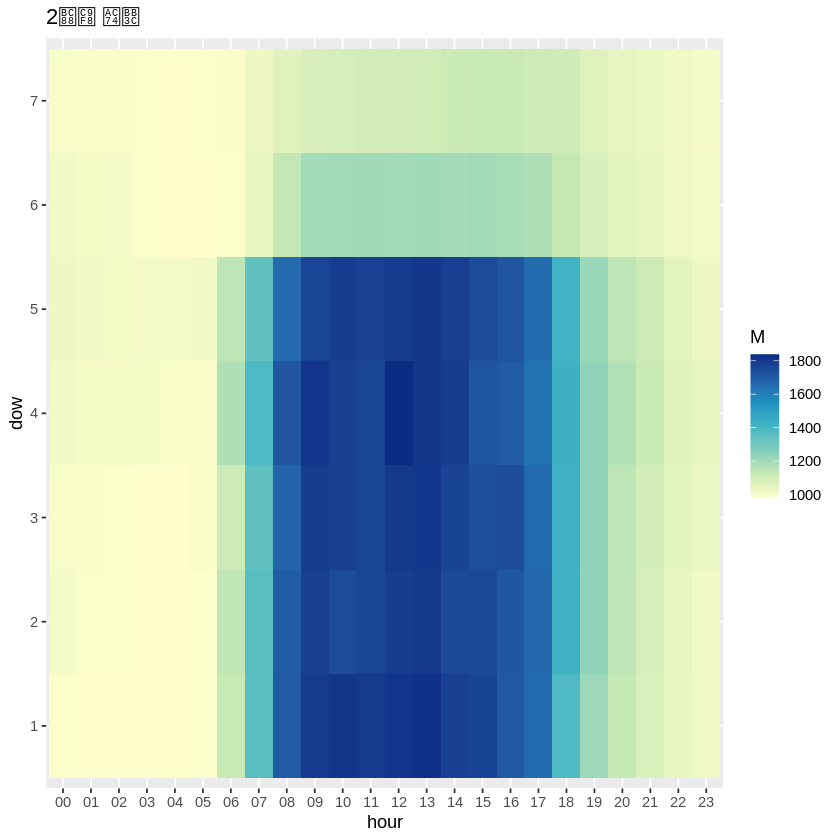

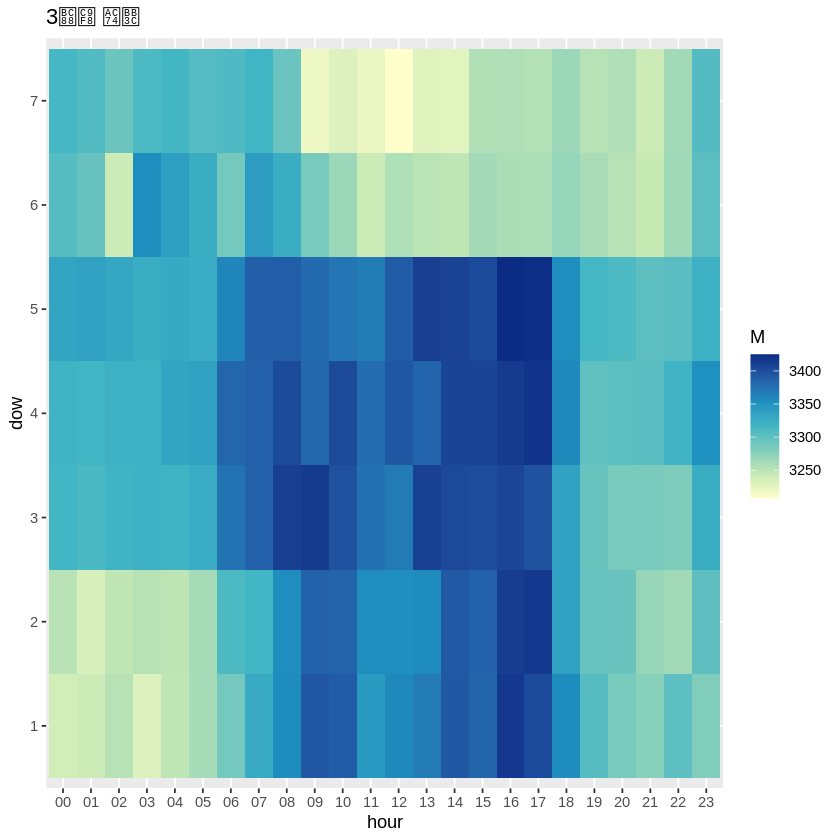

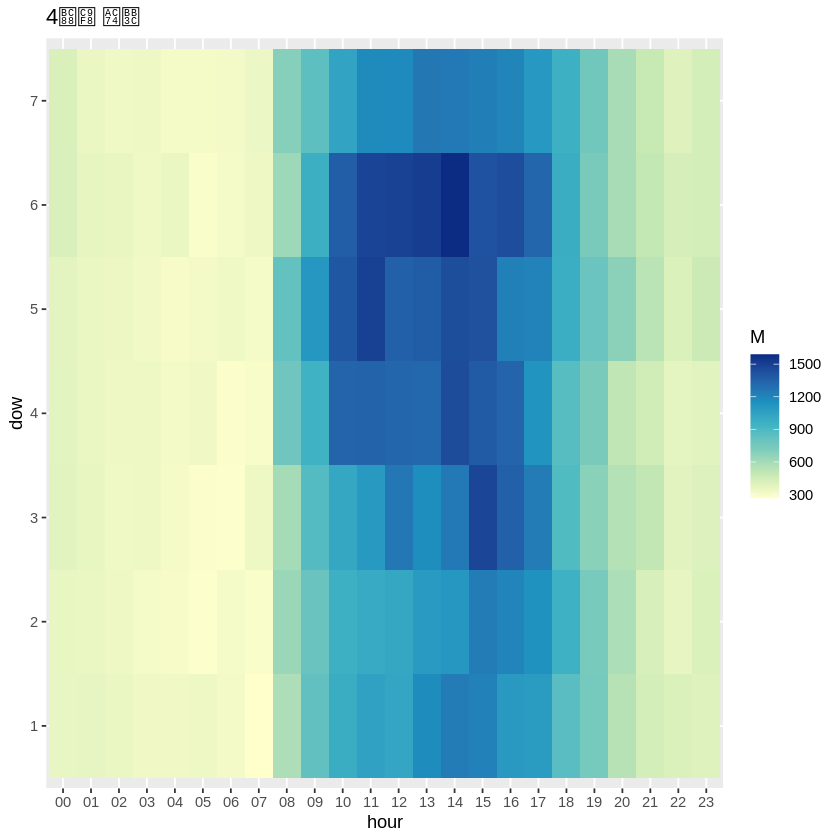

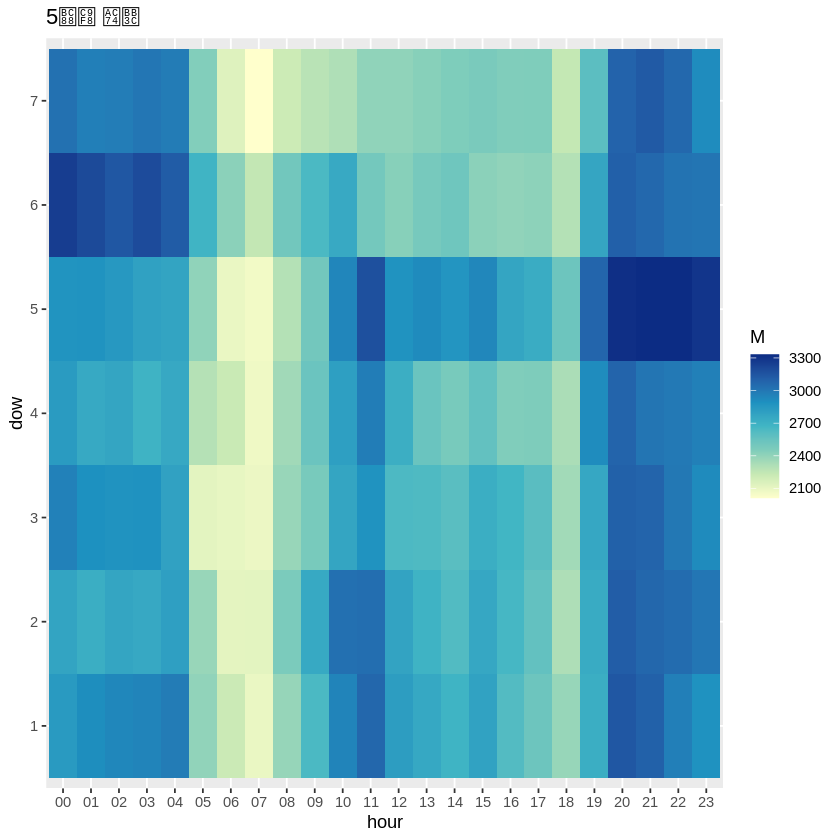

In [6]:
for(i in 1:5){
  p = dt_train[num == i, .(M = median(전력사용량)), by = .(hour, dow)] %>%
  ggplot(aes(hour, dow, fill = M)) +
  geom_tile() +
  scale_fill_distiller(palette = 'YlGnBu', direction = 1) +
  ggtitle(paste0(i, '번째 건물'))
  plot(p)
}

** 시간 및 요일별 전력사용량의 중앙값 계산 (건물마다 존재하는 이상치 보완)

1번째 건물
- 요일 및 시간 상관없이 8400 - 8900 수준
- 항상 돌아가는 공장

2번째 건물
- 월 - 금, 9 to 6, 나머지 시간대에는 전력사용량이 절반 수준
- 사무실

3번째 건물
- 2번과 비슷 BUT 3200 - 3450 수준
- 2번보다는 평일 작업이 많은 공장

4번째 건물
- 밤 - 새벽에는 사람 없음, 목금토 낮에 많이 붐빔
- 낮에만 여는 공원

5번째 건물
- 평일 점심시간, 저녁 8시 이후, 특히 불금 - 토새벽에 사람 몰림
- 먹고 마시는 곳

#### 건물 군집화

24시간을 3시간씩 나눠 건물 /요일/시간대(3시간)별 전력사용량의 중앙값 계산

In [10]:
# 특정 건물의 요일/3시간별 전력사용량
dt_train[, hour_by3 := formatC((as.integer(format(date_time, format = '%H')) %/% 3) * 3, width = 2, flag = '0')]
agg_cl = dt_train[, .(M = median(전력사용량)), by = .(num, hour_by3, dow)]
agg_cl[, R := M/max(M), by = .(num)]
dt_cl = dcast(agg_cl, num ~ dow + hour_by3, value.var = 'R') # 건물번호별 요일과 3시간별 전력사용량

head(dt_train)
head(agg_cl) # M = 전력사용량의 중앙값, R = 최대 전력사용량(1)에 대한 비율
head(dt_cl)

num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,date,hour,dow,hour_by3
<int>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<fct>,<fct>,<chr>
1,2020-06-01 00:00:00,8179.056,17.6,2.5,92,0.8,0,0,0,2020-06-01,00,1,00
1,2020-06-01 01:00:00,8135.640,17.7,2.9,91,0.3,0,0,0,2020-06-01,01,1,00
1,2020-06-01 02:00:00,8107.128,17.5,3.2,91,0.0,0,0,0,2020-06-01,02,1,00
1,2020-06-01 03:00:00,8048.808,17.1,3.2,91,0.0,0,0,0,2020-06-01,03,1,03
1,2020-06-01 04:00:00,8043.624,17.0,3.3,92,0.0,0,0,0,2020-06-01,04,1,03
1,2020-06-01 05:00:00,8010.576,16.9,3.4,93,0.0,0,0,0,2020-06-01,05,1,03


num,hour_by3,dow,M,R
<int>,<chr>,<fct>,<dbl>,<dbl>
1,00,1,8541.288,0.9863803
1,03,1,8499.816,0.9815910
1,06,1,8506.944,0.9824141
1,09,1,8613.216,0.9946868
1,12,1,8643.024,0.9981292
1,15,1,8659.224,1.0000000


num,1_00,1_03,1_06,1_09,1_12,1_15,1_18,1_21,2_00,⋯,6_18,6_21,7_00,7_03,7_06,7_09,7_12,7_15,7_18,7_21
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9863803,0.9815910,0.9824141,0.9946868,0.9981292,1.0000000,0.9914690,0.9900471,0.9842475,⋯,0.9891491,0.9894111,0.9845469,0.9808426,0.9786350,0.9804685,0.9850707,0.9883634,0.9891866,0.9913567
2,0.5407085,0.5385776,0.7381692,0.9851727,0.9936962,0.9370505,0.6666075,0.5788866,0.5463021,⋯,0.5978869,0.5609518,0.5456805,0.5400870,0.5667229,0.5937139,0.6031253,0.6118263,0.5912279,0.5565125
3,0.9487163,0.9509612,0.9813773,0.9895634,0.9868787,0.9955103,0.9727773,0.9602251,0.9508031,⋯,0.9546130,0.9512299,0.9683824,0.9704376,0.9643986,0.9428829,0.9445494,0.9531955,0.9542968,0.9539332
4,0.2355256,0.2138842,0.2172569,0.6017426,0.7391793,0.7144463,0.4747049,0.2689713,0.2245644,⋯,0.5033727,0.2875211,0.2332771,0.2114952,0.2376170,0.6784711,0.7823215,0.7743114,0.4891793,0.2852726
5,0.8785557,0.8268606,0.6811274,0.8808936,0.8354332,0.7942590,0.8101052,0.8901156,0.8238083,⋯,0.8325107,0.9156384,0.9070659,0.8686193,0.6272243,0.6963891,0.7297701,0.7374984,0.7775036,0.9188856
6,0.2304096,0.2226180,0.3579697,0.9654942,0.9906500,0.9479074,0.4792965,0.3032057,0.2587934,⋯,0.2892921,0.2481077,0.2286287,0.2208370,0.2339715,0.2809439,0.3154497,0.3176759,0.2779386,0.2459929


In [14]:
# 계층적 군집화
dist_building = dist(dt_cl[,-1]) # 거리행렬 구하기
hc_building = hclust(dist(dt_cl[, -1]), method='ward.D2') #와드연결법으로 거리행렬 계산하기
## https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=leedk1110&logNo=220800446877

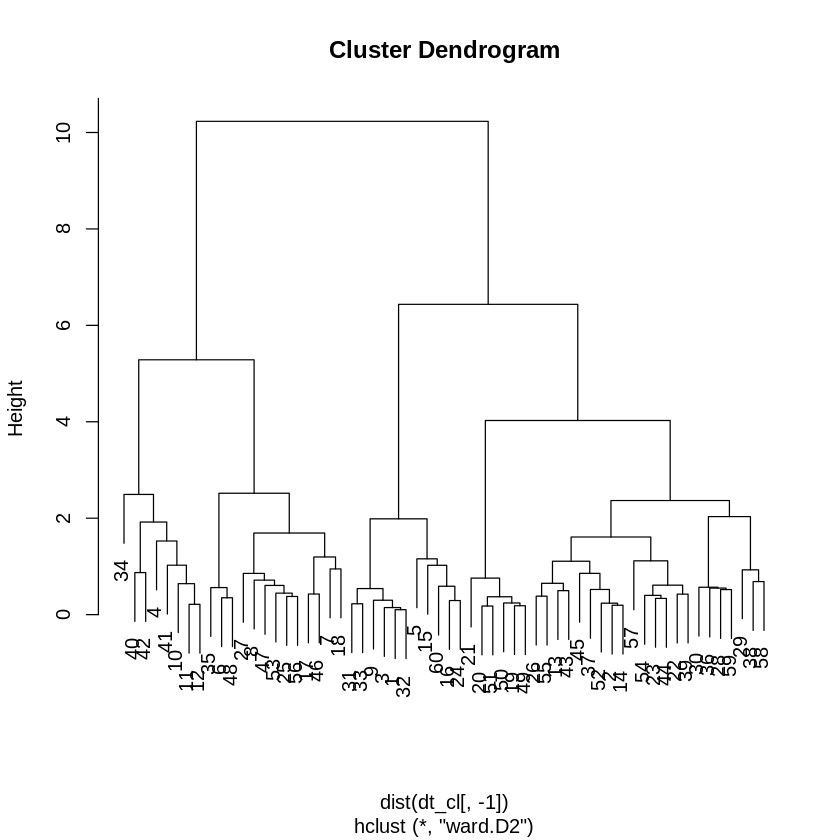

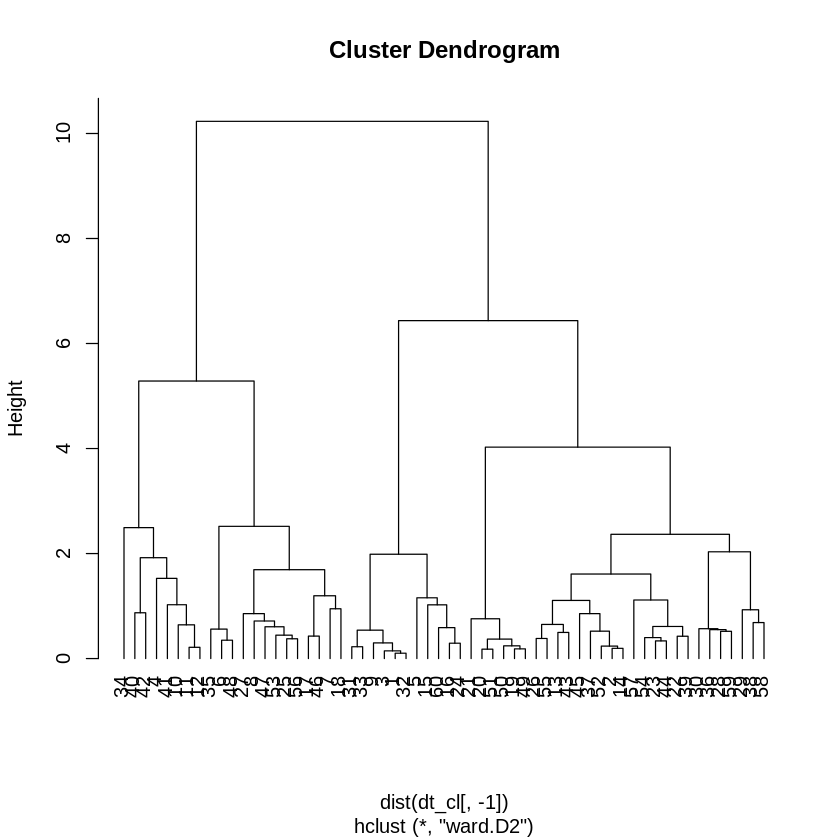

In [17]:
plot(hc_building)
plot(hc_building, hang = -1)

총 5개의 군집이 만들어졌다.

In [18]:
# 군집화 시각화
#fviz_dend(hc_building, k = 5,
#          cex = 0.5,
#          k_colors = RColorBrewer::brewer.pal(5, 'Set1'),
#          color_labels_by_k = TRUE,
#          rect = TRUE,
#          rect_border = RColorBrewer::brewer.pal(5, 'Set1'),
#          rect_fill = TRUE)

#### 군집별 요일/시간대에 따른 전력사용량

In [20]:
dt_cl_result = data.table(num = 1:60, grp = LETTERS[cutree(hc_building, k = 5)])
agg_cl[dt_cl_result, on = .(num), G := i.grp]

head(dt_cl_result)
head(agg_cl)

num,grp
<int>,<chr>
1,A
2,B
3,A
4,C
5,A
6,D


num,hour_by3,dow,M,R,G
<int>,<chr>,<fct>,<dbl>,<dbl>,<chr>
1,00,1,8541.288,0.9863803,A
1,03,1,8499.816,0.9815910,A
1,06,1,8506.944,0.9824141,A
1,09,1,8613.216,0.9946868,A
1,12,1,8643.024,0.9981292,A
1,15,1,8659.224,1.0000000,A


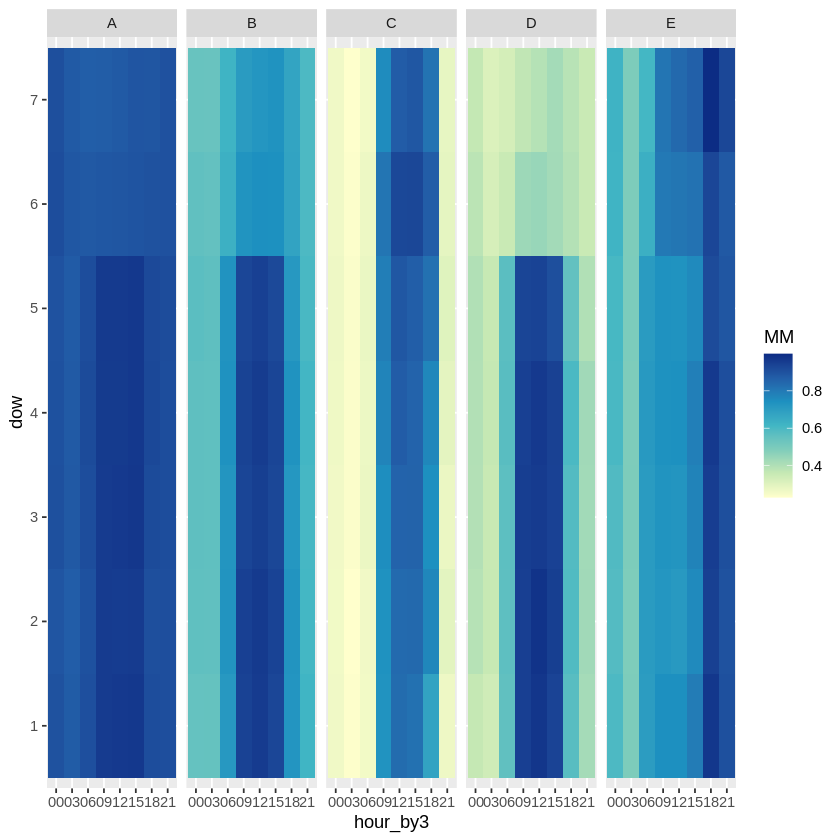

In [21]:
# 군집의 3시간별/요일별 전력사용량
agg_cl[, .(MM = mean(R)), by = .(G, hour_by3, dow)] %>%
  ggplot(aes(hour_by3, dow, fill = MM)) +
  geom_tile() +
  scale_fill_distiller(palette = 'YlGnBu', direction = 1) +
  facet_grid(cols = vars(G))


A
- 요일과 시간 상관없이 항상 전력사용량 많음

B
- 평일 낮시간에 전력사용량 가장 많음
- 나머지 시간에도 %50% 수준 유지

C
- 요일 상관없이 낮시간 전력사용량 많음

D
- 평일 낮시간에 전력사용량 가장 많음
- 주말에는 사용량 낮음

E
- 주말에 전력사용량 많은 편
- 요일 상관없이 저녁에 전력사용량 많음

num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,date,hour,dow,hour_by3,cl_grp
<int>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<fct>,<fct>,<chr>,<chr>
1,2020-06-01 00:00:00,8179.056,17.6,2.5,92,0.8,0,0,0,2020-06-01,00,1,00,A
1,2020-06-01 01:00:00,8135.640,17.7,2.9,91,0.3,0,0,0,2020-06-01,01,1,00,A
1,2020-06-01 02:00:00,8107.128,17.5,3.2,91,0.0,0,0,0,2020-06-01,02,1,00,A
1,2020-06-01 03:00:00,8048.808,17.1,3.2,91,0.0,0,0,0,2020-06-01,03,1,03,A
1,2020-06-01 04:00:00,8043.624,17.0,3.3,92,0.0,0,0,0,2020-06-01,04,1,03,A
1,2020-06-01 05:00:00,8010.576,16.9,3.4,93,0.0,0,0,0,2020-06-01,05,1,03,A


num,cl_grp,date,TOTAL
<int>,<chr>,<date>,<dbl>
1,A,2020-06-01,193194.7
1,A,2020-06-02,190996.1
1,A,2020-06-03,198470.7
1,A,2020-06-04,203034.0
1,A,2020-06-05,206675.1
1,A,2020-06-06,206121.0


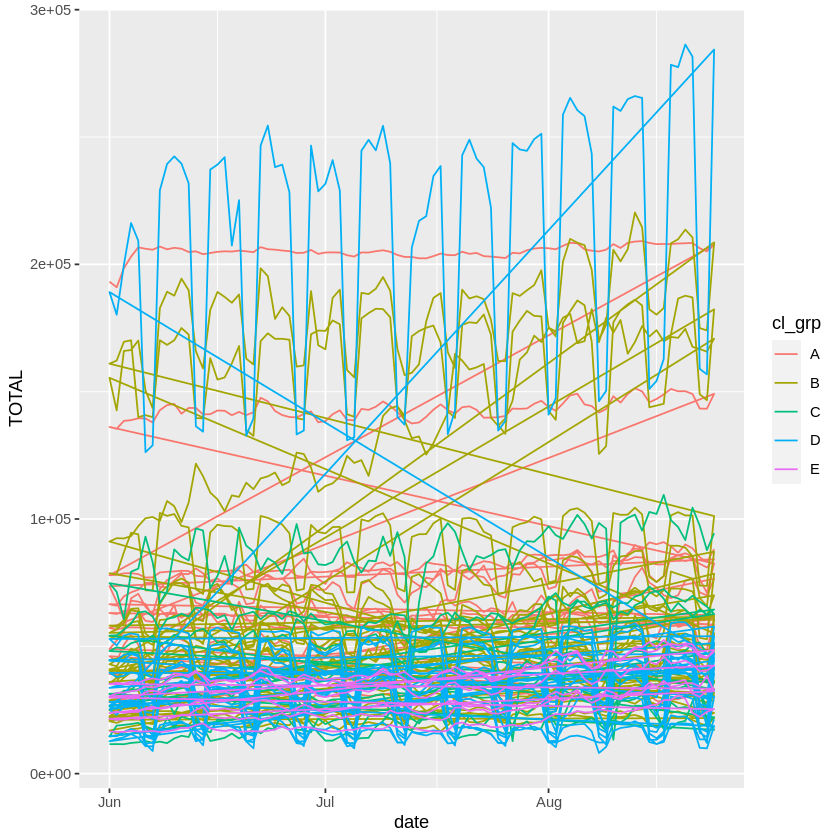

In [36]:
# 일별 전력사용량
dt_train[dt_cl_result, on = .(num), cl_grp := i.grp]
head(dt_train)

p_cl = dt_train[, .(TOTAL = sum(전력사용량)), by = .(num, cl_grp, date)]
head(p_cl)

p_cl_plt = p_cl %>%
  ggplot(aes(date, TOTAL, group - num, color = cl_grp)) +
  geom_path()
p_cl_plt

#### B그룹 데이터 EDA

In [37]:
dt_train_B <- dt_train[dt_train$cl_grp == "B", ]
head(dt_train_B)

p_cl_B <- p_cl[p_cl$cl_grp == "B", ]
head(p_cl_B)

num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,date,hour,dow,hour_by3,cl_grp
<int>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<fct>,<fct>,<chr>,<chr>
2,2020-06-01 00:00:00,977.184,18.3,2.5,94,0,0,1,0,2020-06-01,00,1,00,B
2,2020-06-01 01:00:00,966.168,18.8,2.3,89,0,0,1,0,2020-06-01,01,1,00,B
2,2020-06-01 02:00:00,972.972,19.0,3.2,86,0,0,1,0,2020-06-01,02,1,00,B
2,2020-06-01 03:00:00,965.844,19.0,4.1,85,0,0,1,0,2020-06-01,03,1,03,B
2,2020-06-01 04:00:00,971.676,18.9,3.9,87,0,0,1,0,2020-06-01,04,1,03,B
2,2020-06-01 05:00:00,972.648,18.8,3.3,89,0,0,1,0,2020-06-01,05,1,03,B


num,cl_grp,date,TOTAL
<int>,<chr>,<date>,<dbl>
2,B,2020-06-01,30095.39
2,B,2020-06-02,30243.13
2,B,2020-06-03,31382.64
2,B,2020-06-04,33296.18
2,B,2020-06-05,32570.75
2,B,2020-06-06,25046.82


In [40]:
head(dt_train_B, 10)

num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,date,hour,dow,hour_by3,cl_grp
<int>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<fct>,<fct>,<chr>,<chr>
2,2020-06-01 00:00:00,977.184,18.3,2.5,94,0,0.0,1,0,2020-06-01,00,1,00,B
2,2020-06-01 01:00:00,966.168,18.8,2.3,89,0,0.0,1,0,2020-06-01,01,1,00,B
2,2020-06-01 02:00:00,972.972,19.0,3.2,86,0,0.0,1,0,2020-06-01,02,1,00,B
2,2020-06-01 03:00:00,965.844,19.0,4.1,85,0,0.0,1,0,2020-06-01,03,1,03,B
2,2020-06-01 04:00:00,971.676,18.9,3.9,87,0,0.0,1,0,2020-06-01,04,1,03,B
2,2020-06-01 05:00:00,972.648,18.8,3.3,89,0,0.0,1,0,2020-06-01,05,1,03,B
2,2020-06-01 06:00:00,1041.336,18.6,2.4,91,0,0.0,1,0,2020-06-01,06,1,06,B
2,2020-06-01 07:00:00,1187.136,19.2,5.2,87,0,0.0,1,0,2020-06-01,07,1,06,B
2,2020-06-01 08:00:00,1394.820,20.6,2.5,81,0,0.0,1,0,2020-06-01,08,1,06,B


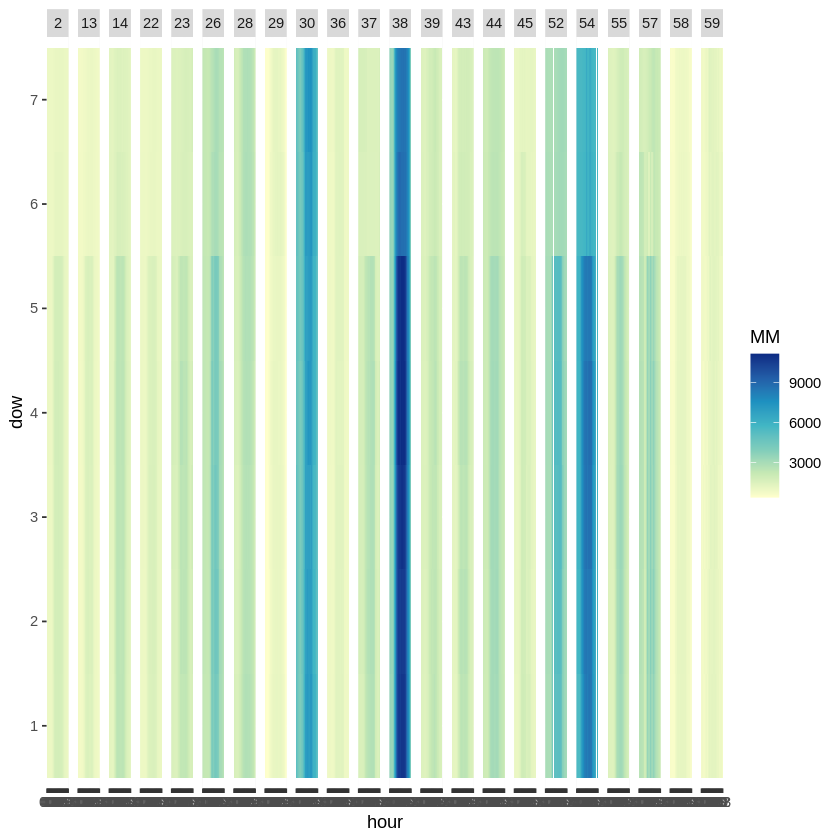

In [61]:
# B군집에 속하는 건물의 시간/요일별 전력사용량
dt_train_B[ , .(MM = mean(전력사용량)), by = .(num, hour, dow)] %>%
  ggplot(aes(hour, dow, fill = MM)) +
  geom_tile() +
  scale_fill_distiller(palette = 'YlGnBu', direction = 1) +
  facet_grid(cols = vars(num))

30번, 38번, 52번, 54번 건물의 전력사용량을 다시 한번 확인해본다.

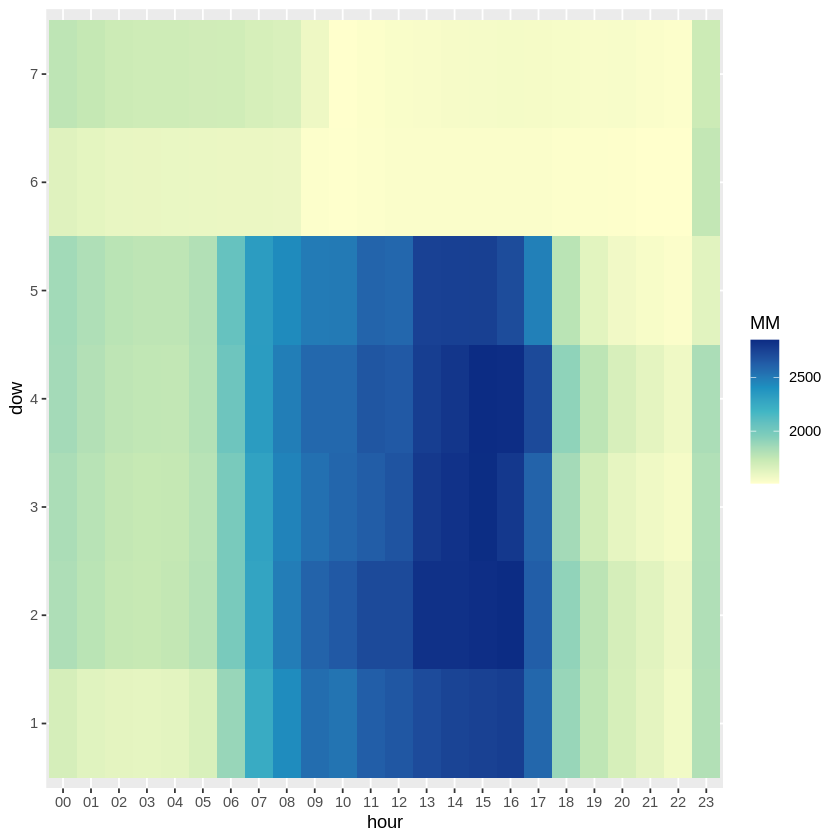

In [75]:
# < B군집의 대표적인 전력사용량 추이 > 37번 건물
dt_train_B[ num == 37, .(MM = mean(전력사용량)), by = .(hour, dow)] %>%
  ggplot(aes(hour, dow, fill = MM)) +
  geom_tile() +
  scale_fill_distiller(palette = 'YlGnBu', direction = 1)

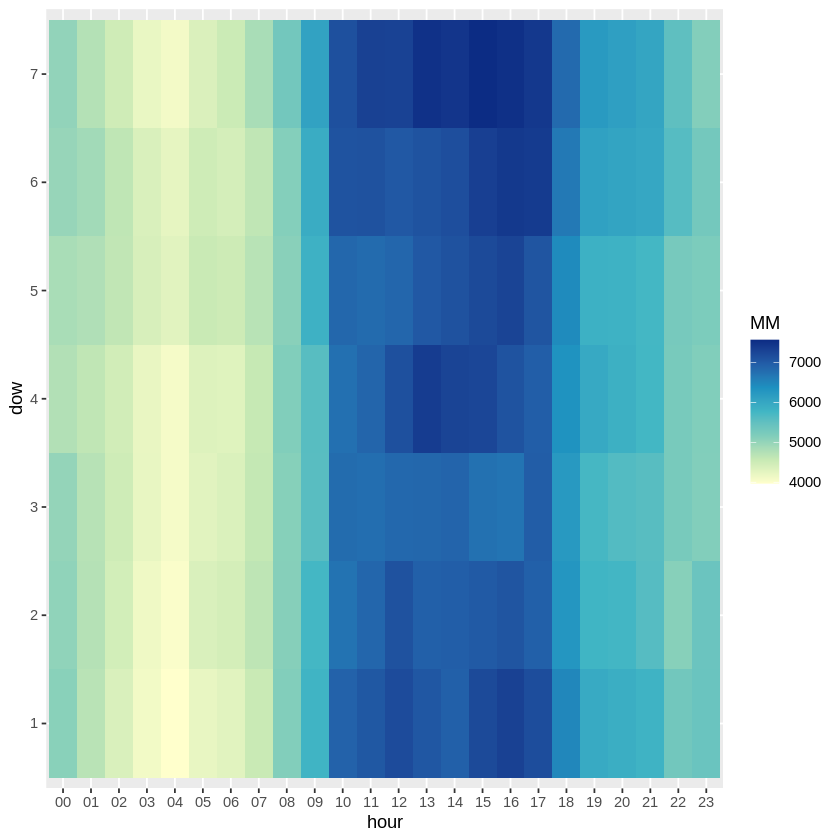

In [73]:
# 30번 건물
dt_train_B[ num == 30, .(MM = mean(전력사용량)), by = .(hour, dow)] %>%
  ggplot(aes(hour, dow, fill = MM)) +
  geom_tile() +
  scale_fill_distiller(palette = 'YlGnBu', direction = 1)

30번 건물
- 평일뿐만큼 주말에도 낮시간 전력사용량이 많음
- 전력사용량이 많은 편에 속함

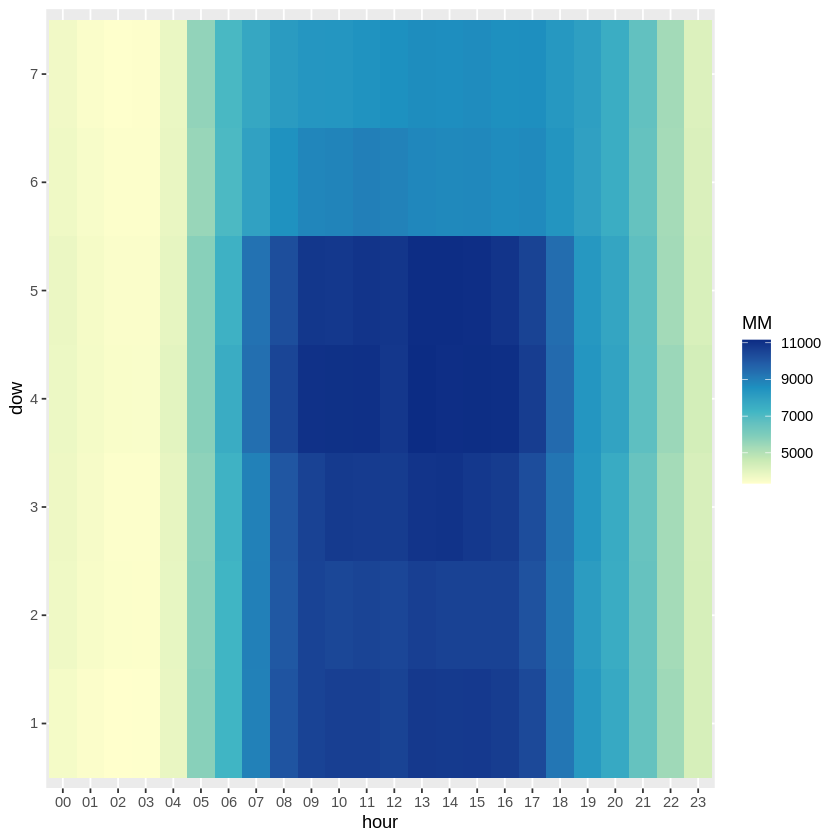

In [74]:
# 38번 건물
dt_train_B[ num == 38, .(MM = mean(전력사용량)), by = .(hour, dow)] %>%
  ggplot(aes(hour, dow, fill = MM)) +
  geom_tile() +
  scale_fill_distiller(palette = 'YlGnBu', direction = 1)

38번 건물
- 주말의 낮시간 전력사용량이 평일보다는 낮음
- 전체적으로 전력사용량이 많은 건물

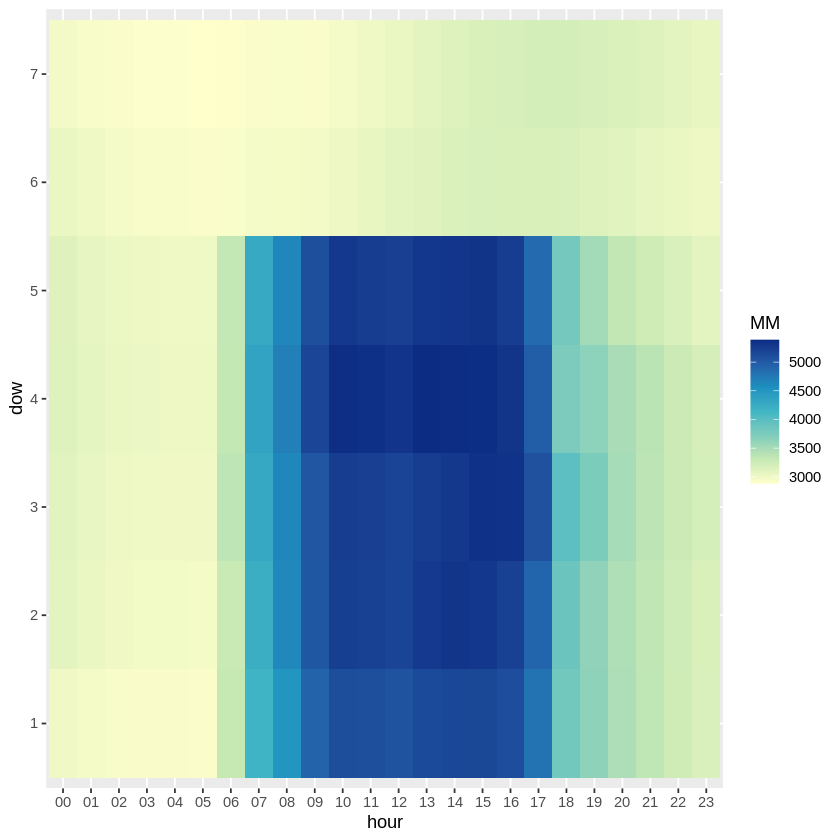

In [76]:
# 52번 건물
dt_train_B[ num == 52, .(MM = mean(전력사용량)), by = .(hour, dow)] %>%
  ggplot(aes(hour, dow, fill = MM)) +
  geom_tile() +
  scale_fill_distiller(palette = 'YlGnBu', direction = 1)

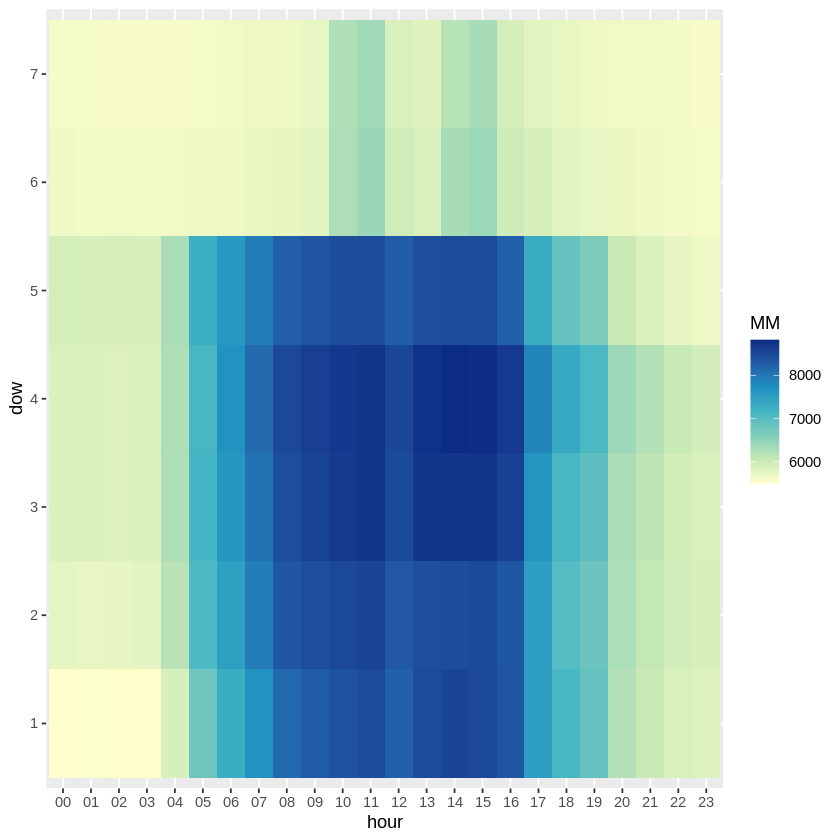

In [77]:
# 54번 건물
dt_train_B[ num == 54, .(MM = mean(전력사용량)), by = .(hour, dow)] %>%
  ggplot(aes(hour, dow, fill = MM)) +
  geom_tile() +
  scale_fill_distiller(palette = 'YlGnBu', direction = 1)

52번, 54번 건물
- 다른 건물들에 비해 전체적으로 전력사용량이 많음
- 평일 낮에 가장 많은 전력사용량을 보임 ==> B군집의 대표적인 특성에 해당, 큰 이상 없는 것으로 판단